ENERGY ARBITRAGE VALUE ANALYSIS including price forecasts with XGB model instead of perfect foresight prices for year 2019.

In [1]:
##############################
## IMPORT AND PREPARE DATA ##
############################
import numpy as np
import pandas as pd
from datetime import datetime
from typing import List
from pyomo.environ import *

# Import data
filename1 = 'HOEP_2015-2019_dataset.csv'
filename2 = 'HOEP_2020.csv'
XGboost_2019 = pd.read_csv('HOEP_2019_forecast_XGB1.csv')
XGboost6_2019 = pd.read_csv('HOEP_2019_forecast_XGB6.csv')
XGboost12_2019 = pd.read_csv('HOEP_2019_forecast_XGB12.csv')
XGboost24_2019 = pd.read_csv('HOEP_2019_forecast_XGB24.csv')

dataframe = pd.read_csv(filename1)
cols_of_interest = ["Date","Hour","HOEP"]
dataframe = dataframe[cols_of_interest]

data_2020 = pd.read_csv(filename2)
data_2020 = data_2020.head(360)
data_2020 = data_2020[cols_of_interest]

dataframe = dataframe.append(data_2020, ignore_index=True)
dataframe['HOEP_lag360'] = dataframe.HOEP.shift(360)
dataframe['HOEP_lag168'] = dataframe.HOEP.shift(168)
dataframe['HOEP_lag24'] = dataframe.HOEP.shift(24)
dataframe['Datetime'] = pd.to_datetime(dataframe.Date) + pd.to_timedelta(dataframe.Hour, unit='h')

# Create different datasets for each year
df_2015 = dataframe.loc[:8759].reset_index(drop=True)
df_2016 = dataframe.loc[8760:17903].reset_index(drop=True)
df_2017 = dataframe.loc[17544:26663].reset_index(drop=True)
df_2018 = dataframe.loc[26304:35423].reset_index(drop=True)

df_2019 = dataframe.loc[35064:].reset_index(drop=True)
df_2019['XGB'] = XGboost_2019.Forecast
df_2019['XGB6'] = XGboost6_2019.Forecast
df_2019['XGB12'] = XGboost12_2019.Forecast
df_2019['XGB24'] = XGboost24_2019.Forecast

# add data at the end of 2019 so the algorithm has additional hours 
# of info to get optimization until the last period. Because it uses future info up to 12 periods.
data = df_2019.copy()
data = data.fillna(0)
data

,Date,Hour,HOEP,HOEP_lag360,HOEP_lag168,HOEP_lag24,Datetime,XGB,XGB6,XGB12,XGB13,XGB24
0,2019-01-01,1,0.00,3.48,14.35,20.44,2019-01-01 01:00:00,0.405360,1.734116,2.580984,3.828087,0.550321
1,2019-01-01,2,0.00,14.31,24.19,13.33,2019-01-01 02:00:00,0.770444,1.849441,5.863590,2.651484,0.525895
2,2019-01-01,3,-0.11,13.63,14.39,13.35,2019-01-01 03:00:00,0.770444,1.849441,5.975186,5.025017,0.525895
3,2019-01-01,4,-1.84,2.04,14.39,28.51,2019-01-01 04:00:00,0.439540,0.777622,4.963967,2.348048,0.525895
4,2019-01-01,5,-0.47,1.21,23.40,26.66,2019-01-01 05:00:00,0.439540,0.777622,5.308259,2.651484,0.813945
...,...,...,...,...,...,...,...,...,...,...,...,...
9115,2020-01-15,20,21.96,0.00,41.25,17.39,2020-01-15 20:00:00,0.000000,0.000000,0.000000,0.000000,0.000000
9116,2020-01-15,21,23.44,0.00,26.48,14.40,2020-01-15 21:00:00,0.000000,0.000000,0.000000,0.000000,0.000000
9117,2020-01-15,22,29.22,-0.05,16.71,14.00,2020-01-15 22:00:00,0.000000,0.000000,0.000000,0.000000,0.000000
9118,2020-01-15,23,15.66,-0.04,20.82,16.27,2020-01-15 23:00:00,0.000000,0.000000,0.000000,0.000000,0.000000


In [3]:
########################################################################################
####################################  2019lo #############################################
### OPTIMIZATION WITH 12h XGBoost rolling horizon using Model 1 (M1) price forecast ###
#######################################################################################

# M1 2018, horizon = 12h
start_time = datetime.now()

list_Date = []
list_HOEP = []
list_XGB = []
list_XGB12 = []
list_SOC = []
list_Ein = []
list_Eout = []
list_value = []

horizon = 11
duration = 12

for i in range(0,8760): 
    
    df = data.loc[0+i:horizon+i]
    df.reset_index(inplace=True)

    model = ConcreteModel()
    
    # Variables of the model
    model.T = Set(initialize=df.index, ordered=True)
    model.Rmax = Param(initialize=1, within=Any) 
    model.Smax = Param(initialize=duration, within=Any)
    model.Dmax = Param(initialize=duration, within=Any) 

    model.Ein = Var(model.T, domain=NonNegativeReals)  
    model.Eout = Var(model.T, domain=NonNegativeReals) 
    model.Z = Var(model.T, domain=NonNegativeReals)  
    model.L = Var(model.T, domain=NonNegativeReals) 
    model.value = Var(model.T)
    model.eta = Param(initialize=0.86)

    # Constraints
    def storage_state(model, t):
        if df['Datetime'].iloc[0] == data.Datetime[0]:  
            if t == model.T.first():
                return model.Z[t] == duration/2  
            else:
                return model.Z[t] == model.Z[t-1] + model.Ein[t]*model.eta - model.Eout[t]
        else:
            if t == model.T.first():
                return model.Z[t] == SOC + model.Ein[t]*model.eta - model.Eout[t]
            else:
                return model.Z[t] == model.Z[t-1] + model.Ein[t]*model.eta - model.Eout[t]
    model.charge_state = Constraint(model.T, rule=storage_state)

    def discharge_constraint(model, t):
        return model.Eout[t] <= model.Rmax
    model.discharge = Constraint(model.T, rule=discharge_constraint)

    def charge_constraint(model, t):
        return model.Ein[t] <= model.Rmax
    model.charge = Constraint(model.T, rule=charge_constraint)

    def positive_charge(model, t): 
        return model.Eout[t] <= model.Z[t] 
    model.positive_charge = Constraint(model.T, rule=positive_charge)

    def max_SOC(model, t): 
        return model.Z[t] <= model.Smax
    model.max_SOC = Constraint(model.T, rule=max_SOC)
    
    def value_constraint(model, t):
        if t == model.T.first():
            return model.value[t] == (model.Eout[t] - model.Ein[t]) * df.loc[t,'XGB']
        else:
            return model.value[t] == (model.Eout[t] - model.Ein[t]) * df.loc[t,'XGB12']               
    model.value_constraint = Constraint(model.T, rule=value_constraint)

    # Objective function and optimization
    profits = sum(model.value[t] for t in model.T)
    model.objective = Objective(expr=profits, sense=maximize)

    # Solve model
    solver = SolverFactory('glpk')
    solver.solve(model) 
    
    # Extract model output in list
    Date = list(df['Datetime'])[0]
    HOEP = list(df['HOEP'])[0]
    XGB = list(df['XGB'])[0]
    XGB12 = list(df['XGB12'])[0]
    SOC = list(model.Z.get_values().values())[0]
    Ein= list(model.Ein.get_values().values())[0]
    Eout = list(model.Eout.get_values().values())[0]
    value = list(model.value.get_values().values())[0]
    
    list_Date.append(Date)
    list_HOEP.append(HOEP)
    list_XGB.append(XGB)
    list_XGB12.append(XGB12)
    list_SOC.append(SOC)
    list_Ein.append(Ein)
    list_Eout.append(Eout)
    list_value.append(value)

# Present final results in a dataframe
results = pd.DataFrame(list_Date, columns=['Datetime'])
results['HOEP'] = list_HOEP
results['XGB'] = list_XGB
results['XGB12'] = list_XGB12
results['Ein'] = list_Ein
results['Eout'] = list_Eout
results['SOC'] = list_SOC
results['value'] = list_value
results['real_value'] = (results.Eout - results.Ein)*results.HOEP
results = results.round(2)
remaining_value = (results.loc[results['Eout'] > 0, 'HOEP'].mean() * results.SOC.tail(1)) 

print("running time:", datetime.now() - start_time)
print("real value of storage:", (results.real_value.sum() + remaining_value.item())/1000)
XGB_2019 = (results.real_value.sum() + remaining_value.item())/1000
results

running time: 0:15:44.889587
real value of storage: 23.930371303759802


,Datetime,HOEP,XGB,XGB12,Ein,Eout,SOC,value,real_value
0,2019-01-01 01:00:00,0.00,0.41,2.58,0.0,1.0,6.00,0.41,0.00
1,2019-01-01 02:00:00,0.00,0.77,5.86,1.0,0.0,6.86,-0.77,-0.00
2,2019-01-01 03:00:00,-0.11,0.77,5.98,1.0,0.0,7.72,-0.77,0.11
3,2019-01-01 04:00:00,-1.84,0.44,4.96,1.0,0.0,8.58,-0.44,1.84
4,2019-01-01 05:00:00,-0.47,0.44,5.31,1.0,0.0,9.44,-0.44,0.47
...,...,...,...,...,...,...,...,...,...
8755,2019-12-31 20:00:00,0.00,4.19,11.32,0.0,1.0,5.00,4.19,0.00
8756,2019-12-31 21:00:00,0.00,4.19,10.37,0.0,1.0,4.00,4.19,0.00
8757,2019-12-31 22:00:00,-0.05,3.99,10.82,0.0,1.0,3.00,3.99,-0.05
8758,2019-12-31 23:00:00,-0.04,3.99,10.21,0.0,1.0,2.00,3.99,-0.04


In [6]:
########################################################################################
####################################  2019 #############################################
### OPTIMIZATION WITH 12h XGBoost rolling horizon using Model 2 (M2) price forecast ###
#######################################################################################

# M2 2018, horizon = 24h
start_time = datetime.now()

list_Date = []
list_HOEP = []
list_XGB = []
list_XGB24 = []
list_SOC = []
list_Ein = []
list_Eout = []
list_value = []

horizon = 23
duration = 12

for i in range(0,8760): 
    
    df = data.loc[0+i:horizon+i]
    df.reset_index(inplace=True)

    model = ConcreteModel()
    
    # Variables of the model
    model.T = Set(initialize=df.index, ordered=True)
    model.Rmax = Param(initialize=1, within=Any) 
    model.Smax = Param(initialize=duration, within=Any)
    model.Dmax = Param(initialize=duration, within=Any) 

    model.Ein = Var(model.T, domain=NonNegativeReals)  
    model.Eout = Var(model.T, domain=NonNegativeReals) 
    model.Z = Var(model.T, domain=NonNegativeReals)  
    model.L = Var(model.T, domain=NonNegativeReals) 
    model.value = Var(model.T)
    model.eta = Param(initialize=0.86)

    # Constraints
    def storage_state(model, t):
        if df['Datetime'].iloc[0] == data.Datetime[0]:  
            if t == model.T.first():
                return model.Z[t] == duration/2  
            else:
                return model.Z[t] == model.Z[t-1] + model.Ein[t]*model.eta - model.Eout[t]
        else:
            if t == model.T.first():
                return model.Z[t] == SOC + model.Ein[t]*model.eta - model.Eout[t]
            else:
                return model.Z[t] == model.Z[t-1] + model.Ein[t]*model.eta - model.Eout[t]
    model.charge_state = Constraint(model.T, rule=storage_state)

    def discharge_constraint(model, t):
        return model.Eout[t] <= model.Rmax
    model.discharge = Constraint(model.T, rule=discharge_constraint)

    def charge_constraint(model, t):
        return model.Ein[t] <= model.Rmax
    model.charge = Constraint(model.T, rule=charge_constraint)

    def positive_charge(model, t): 
        return model.Eout[t] <= model.Z[t] 
    model.positive_charge = Constraint(model.T, rule=positive_charge)

    def max_SOC(model, t): 
        return model.Z[t] <= model.Smax
    model.max_SOC = Constraint(model.T, rule=max_SOC)
    
    def value_constraint(model, t):
        if t == model.T.first():
            return model.value[t] == (model.Eout[t] - model.Ein[t]) * df.loc[t,'XGB']
        else:
            return model.value[t] == (model.Eout[t] - model.Ein[t]) * df.loc[t,'XGB24']               
    model.value_constraint = Constraint(model.T, rule=value_constraint)

    # Objective function and optimization
    profits = sum(model.value[t] for t in model.T)
    model.objective = Objective(expr=profits, sense=maximize)

    # Solve model
    solver = SolverFactory('glpk')
    solver.solve(model) 
    
    # Extract model output in list
    Date = list(df['Datetime'])[0]
    HOEP = list(df['HOEP'])[0]
    XGB = list(df['XGB'])[0]
    XGB24 = list(df['XGB24'])[0]
    SOC = list(model.Z.get_values().values())[0]
    Ein= list(model.Ein.get_values().values())[0]
    Eout = list(model.Eout.get_values().values())[0]
    value = list(model.value.get_values().values())[0]
    
    list_Date.append(Date)
    list_HOEP.append(HOEP)
    list_XGB.append(XGB)
    list_XGB24.append(XGB24)
    list_SOC.append(SOC)
    list_Ein.append(Ein)
    list_Eout.append(Eout)
    list_value.append(value)

# Present final results in a dataframe
results = pd.DataFrame(list_Date, columns=['Datetime'])
results['HOEP'] = list_HOEP
results['XGB'] = list_XGB
results['XGB24'] = list_XGB24
results['Ein'] = list_Ein
results['Eout'] = list_Eout
results['SOC'] = list_SOC
results['value'] = list_value
results['real_value'] = (results.Eout - results.Ein)*results.HOEP
results = results.round(2)
remaining_value = (results.loc[results['Eout'] > 0, 'HOEP'].mean() * results.SOC.tail(1)) 

print("running time:", datetime.now() - start_time)
print("real value of storage:", (results.real_value.sum() + remaining_value.item())/1000)
XGB_2019 = (results.real_value.sum() + remaining_value.item())/1000
results

running time: 0:30:01.455297
real value of storage: 25.255650061079546


,Datetime,HOEP,XGB,XGB24,Ein,Eout,SOC,value,real_value
0,2019-01-01 01:00:00,0.00,0.41,0.55,0.0,1.0,6.00,0.41,0.00
1,2019-01-01 02:00:00,0.00,0.77,0.53,1.0,0.0,6.86,-0.77,-0.00
2,2019-01-01 03:00:00,-0.11,0.77,0.53,1.0,0.0,7.72,-0.77,0.11
3,2019-01-01 04:00:00,-1.84,0.44,0.53,1.0,0.0,8.58,-0.44,1.84
4,2019-01-01 05:00:00,-0.47,0.44,0.81,1.0,0.0,9.44,-0.44,0.47
...,...,...,...,...,...,...,...,...,...
8755,2019-12-31 20:00:00,0.00,4.19,6.20,0.0,1.0,4.00,4.19,0.00
8756,2019-12-31 21:00:00,0.00,4.19,6.43,0.0,1.0,3.00,4.19,0.00
8757,2019-12-31 22:00:00,-0.05,3.99,6.20,0.0,1.0,2.00,3.99,-0.05
8758,2019-12-31 23:00:00,-0.04,3.99,6.19,0.0,1.0,1.00,3.99,-0.04


In [4]:
########################################################################################
####################################  2019 #############################################
### OPTIMIZATION WITH 12h XGBoost rolling horizon using Model 7 (M7) price forecast ###
#######################################################################################

# M7 2018, horizon = 360h
start_time = datetime.now()

list_Date = []
list_HOEP = []
list_XGB = []
list_XGB12 = []
list_HOEP_lag168 = []
list_HOEP_lag360 = []
list_SOC = []
list_Ein = []
list_Eout = []
list_value = []

horizon = 359
duration = 12

for i in range(0,8760): 
    
    df = data.loc[0+i:horizon+i]
    df.reset_index(inplace=True)

    model = ConcreteModel()
    
    # Variables of the model
    model.T = Set(initialize=df.index, ordered=True)
    model.Rmax = Param(initialize=1, within=Any) 
    model.Smax = Param(initialize=duration, within=Any)
    model.Dmax = Param(initialize=duration, within=Any) 
    model.eta = Param(initialize=0.86)
    model.Ein = Var(model.T, domain=NonNegativeReals)  
    model.Eout = Var(model.T, domain=NonNegativeReals) 
    model.Z = Var(model.T, domain=NonNegativeReals)  
    model.L = Var(model.T, domain=NonNegativeReals) 
    model.value = Var(model.T)
    
    # Constraints
    def storage_state(model, t):
        if df['Datetime'].iloc[0] == data.Datetime[0]:  
            if t == model.T.first():
                return model.Z[t] == duration/2  
            else:
                return model.Z[t] == model.Z[t-1] + model.Ein[t]*model.eta - model.Eout[t]
        else:
            if t == model.T.first():
                return model.Z[t] == SOC + model.Ein[t]*model.eta - model.Eout[t]
            else:
                return model.Z[t] == model.Z[t-1] + model.Ein[t]*model.eta - model.Eout[t]
    model.charge_state = Constraint(model.T, rule=storage_state)

    def discharge_constraint(model, t):
        return model.Eout[t] <= model.Rmax
    model.discharge = Constraint(model.T, rule=discharge_constraint)

    def charge_constraint(model, t):
        return model.Ein[t] <= model.Rmax
    model.charge = Constraint(model.T, rule=charge_constraint)

    def positive_charge(model, t): 
        return model.Eout[t] <= model.Z[t] 
    model.positive_charge = Constraint(model.T, rule=positive_charge)

    def max_SOC(model, t): 
        return model.Z[t] <= model.Smax
    model.max_SOC = Constraint(model.T, rule=max_SOC)
    
    def value_constraint(model, t):
        if t == model.T.first():
            return model.value[t] == (model.Eout[t] - model.Ein[t]) * df.loc[t,'XGB']
        else:
            if t in range(1,12):
                return model.value[t] == (model.Eout[t] - model.Ein[t]) * df.loc[t,'XGB12']
            else:
                if t in range(13,168):
                    return model.value[t] == (model.Eout[t] - model.Ein[t]) * df.loc[t,'HOEP_lag168']
                else:
                    return model.value[t] == (model.Eout[t] - model.Ein[t]) * df.loc[t,'HOEP_lag360']       
    model.value_constraint = Constraint(model.T, rule=value_constraint)

    # Objective function and optimization
    profits = sum(model.value[t] for t in model.T)
    model.objective = Objective(expr=profits, sense=maximize)

    # Solve model
    solver = SolverFactory('ipopt')
    solver.solve(model) 
    
    # Extract model output in list
    Date = list(df['Datetime'])[0]
    HOEP = list(df['HOEP'])[0]
    XGB = list(df['XGB'])[0]
    XGB12 = list(df['XGB12'])[0]
    HOEP_lag168 = list(df['HOEP_lag168'])[0]
    HOEP_lag360 = list(df['HOEP_lag360'])[0]
    SOC = list(model.Z.get_values().values())[0]
    Ein= list(model.Ein.get_values().values())[0]
    Eout = list(model.Eout.get_values().values())[0]
    value = list(model.value.get_values().values())[0]
    
    list_Date.append(Date)
    list_HOEP.append(HOEP)
    list_XGB.append(XGB)
    list_XGB12.append(XGB12)
    list_HOEP_lag168.append(HOEP_lag168)
    list_HOEP_lag360.append(HOEP_lag360)
    list_SOC.append(SOC)
    list_Ein.append(Ein)
    list_Eout.append(Eout)
    list_value.append(value)

# Present final results in a dataframe
results = pd.DataFrame(list_Date, columns=['Datetime'])
results['HOEP'] = list_HOEP
results['XGB'] = list_XGB
results['XGB12'] = list_XGB12
results['HOEP_lag168'] = list_HOEP_lag168
results['HOEP_lag360'] = list_HOEP_lag360
results['Ein'] = list_Ein
results['Eout'] = list_Eout
results['SOC'] = list_SOC
results['value'] = list_value
results['real_value'] = (results.Eout - results.Ein)*results.HOEP
results = results.round(2)
remaining_value = (results.loc[results['Eout'] > 0, 'HOEP'].mean() * results.SOC.tail(1)) 

print("running time:", datetime.now() - start_time)
print("real value of storage:", (results.real_value.sum() + remaining_value.item())/1000)
XGB_2019 = (results.real_value.sum() + remaining_value.item())/1000
results

running time: 2:22:29.680333
real value of storage: 26.285677970538927


,Datetime,HOEP,XGB,XGB12,HOEP_lag168,HOEP_lag360,Ein,Eout,SOC,value,real_value
0,2019-01-01 01:00:00,0.00,0.41,2.58,14.35,3.48,0.0,1.0,6.00,0.41,0.00
1,2019-01-01 02:00:00,0.00,0.77,5.86,24.19,14.31,1.0,0.0,6.86,-0.77,-0.00
2,2019-01-01 03:00:00,-0.11,0.77,5.98,14.39,13.63,1.0,0.0,7.72,-0.77,0.11
3,2019-01-01 04:00:00,-1.84,0.44,4.96,14.39,2.04,1.0,0.0,8.58,-0.44,1.84
4,2019-01-01 05:00:00,-0.47,0.44,5.31,23.40,1.21,1.0,0.0,9.44,-0.44,0.47
...,...,...,...,...,...,...,...,...,...,...,...
8755,2019-12-31 20:00:00,0.00,4.19,11.32,14.57,25.52,0.0,1.0,10.84,4.19,0.00
8756,2019-12-31 21:00:00,0.00,4.19,10.37,13.34,25.51,0.0,1.0,9.84,4.19,0.00
8757,2019-12-31 22:00:00,-0.05,3.99,10.82,14.39,24.72,0.0,1.0,8.84,3.99,-0.05
8758,2019-12-31 23:00:00,-0.04,3.99,10.21,37.15,24.52,0.0,1.0,7.84,3.99,-0.04


In [7]:
########################################################################################
####################################  2019 #############################################
### OPTIMIZATION WITH 12h XGBoost rolling horizon using Model 5 (M5) price forecast ###
#######################################################################################

# M5 2018, horizon = 360h
start_time = datetime.now()

list_Date = []
list_HOEP = []
list_XGB = []
list_XGB24 = []
list_HOEP_lag168 = []
list_HOEP_lag360 = []
list_SOC = []
list_Ein = []
list_Eout = []
list_value = []

horizon = 359
duration = 12

for i in range(0,8760): 
    
    df = data.loc[0+i:horizon+i]
    df.reset_index(inplace=True)

    model = ConcreteModel()
    
    # Variables of the model
    model.T = Set(initialize=df.index, ordered=True)
    model.Rmax = Param(initialize=1, within=Any) 
    model.Smax = Param(initialize=duration, within=Any)
    model.Dmax = Param(initialize=duration, within=Any) 
    model.eta = Param(initialize=0.86)
    model.Ein = Var(model.T, domain=NonNegativeReals)  
    model.Eout = Var(model.T, domain=NonNegativeReals) 
    model.Z = Var(model.T, domain=NonNegativeReals)  
    model.L = Var(model.T, domain=NonNegativeReals) 
    model.value = Var(model.T)
    
    # Constraints
    def storage_state(model, t):
        if df['Datetime'].iloc[0] == data.Datetime[0]:  
            if t == model.T.first():
                return model.Z[t] == duration/2  
            else:
                return model.Z[t] == model.Z[t-1] + model.Ein[t]*model.eta - model.Eout[t]
        else:
            if t == model.T.first():
                return model.Z[t] == SOC + model.Ein[t]*model.eta - model.Eout[t]
            else:
                return model.Z[t] == model.Z[t-1] + model.Ein[t]*model.eta - model.Eout[t]
    model.charge_state = Constraint(model.T, rule=storage_state)

    def discharge_constraint(model, t):
        return model.Eout[t] <= model.Rmax
    model.discharge = Constraint(model.T, rule=discharge_constraint)

    def charge_constraint(model, t):
        return model.Ein[t] <= model.Rmax
    model.charge = Constraint(model.T, rule=charge_constraint)

    def positive_charge(model, t): 
        return model.Eout[t] <= model.Z[t] 
    model.positive_charge = Constraint(model.T, rule=positive_charge)

    def max_SOC(model, t): 
        return model.Z[t] <= model.Smax
    model.max_SOC = Constraint(model.T, rule=max_SOC)
    
    def value_constraint(model, t):
        if t == model.T.first():
            return model.value[t] == (model.Eout[t] - model.Ein[t]) * df.loc[t,'XGB']
        else:
            if t in range(1,24):
                return model.value[t] == (model.Eout[t] - model.Ein[t]) * df.loc[t,'XGB24']
            else:
                if t in range(24,168):
                    return model.value[t] == (model.Eout[t] - model.Ein[t]) * df.loc[t,'HOEP_lag168']
                else:
                    return model.value[t] == (model.Eout[t] - model.Ein[t]) * df.loc[t,'HOEP_lag360']       
    model.value_constraint = Constraint(model.T, rule=value_constraint)

    # Objective function and optimization
    profits = sum(model.value[t] for t in model.T)
    model.objective = Objective(expr=profits, sense=maximize)

    # Solve model
    solver = SolverFactory('ipopt')
    solver.solve(model) 
    
    # Extract model output in list
    Date = list(df['Datetime'])[0]
    HOEP = list(df['HOEP'])[0]
    XGB = list(df['XGB'])[0]
    XGB24 = list(df['XGB24'])[0]
    HOEP_lag168 = list(df['HOEP_lag168'])[0]
    HOEP_lag360 = list(df['HOEP_lag360'])[0]
    SOC = list(model.Z.get_values().values())[0]
    Ein= list(model.Ein.get_values().values())[0]
    Eout = list(model.Eout.get_values().values())[0]
    value = list(model.value.get_values().values())[0]
    
    list_Date.append(Date)
    list_HOEP.append(HOEP)
    list_XGB.append(XGB)
    list_XGB24.append(XGB24)
    list_HOEP_lag168.append(HOEP_lag168)
    list_HOEP_lag360.append(HOEP_lag360)
    list_SOC.append(SOC)
    list_Ein.append(Ein)
    list_Eout.append(Eout)
    list_value.append(value)

# Present final results in a dataframe
results = pd.DataFrame(list_Date, columns=['Datetime'])
results['HOEP'] = list_HOEP
results['XGB'] = list_XGB
results['XGB24'] = list_XGB24
results['HOEP_lag168'] = list_HOEP_lag168
results['HOEP_lag360'] = list_HOEP_lag360
results['Ein'] = list_Ein
results['Eout'] = list_Eout
results['SOC'] = list_SOC
results['value'] = list_value
results['real_value'] = (results.Eout - results.Ein)*results.HOEP
results = results.round(2)
remaining_value = (results.loc[results['Eout'] > 0, 'HOEP'].mean() * results.SOC.tail(1)) 

print("running time:", datetime.now() - start_time)
print("real value of storage:", (results.real_value.sum() + remaining_value.item())/1000)
XGB_2019 = (results.real_value.sum() + remaining_value.item())/1000
results

running time: 2:23:10.696922
real value of storage: 24.30541161851415


,Datetime,HOEP,XGB,XGB24,HOEP_lag168,HOEP_lag360,Ein,Eout,SOC,value,real_value
0,2019-01-01 01:00:00,0.00,0.41,0.55,14.35,3.48,0.0,1.0,6.00,0.41,0.00
1,2019-01-01 02:00:00,0.00,0.77,0.53,24.19,14.31,1.0,0.0,6.86,-0.77,-0.00
2,2019-01-01 03:00:00,-0.11,0.77,0.53,14.39,13.63,1.0,0.0,7.72,-0.77,0.11
3,2019-01-01 04:00:00,-1.84,0.44,0.53,14.39,2.04,1.0,0.0,8.58,-0.44,1.84
4,2019-01-01 05:00:00,-0.47,0.44,0.81,23.40,1.21,1.0,0.0,9.44,-0.44,0.47
...,...,...,...,...,...,...,...,...,...,...,...
8755,2019-12-31 20:00:00,0.00,4.19,6.20,14.57,25.52,0.0,1.0,5.00,4.19,0.00
8756,2019-12-31 21:00:00,0.00,4.19,6.43,13.34,25.51,0.0,1.0,4.00,4.19,0.00
8757,2019-12-31 22:00:00,-0.05,3.99,6.20,14.39,24.72,0.0,1.0,3.00,3.99,-0.05
8758,2019-12-31 23:00:00,-0.04,3.99,6.19,37.15,24.52,0.0,1.0,2.00,3.99,-0.04


In [2]:
########################################################################################
####################################  2019 #############################################
### OPTIMIZATION WITH 12h XGBoost rolling horizon using Model 9 (M9) price forecast ###
#######################################################################################

# M9 2018, horizon = 168h
start_time = datetime.now()

list_Date = []
list_HOEP = []
list_XGB = []
list_XGB12 = []
list_XGB24 = []
list_HOEP_lag168 = []
list_SOC = []
list_Ein = []
list_Eout = []
list_value = []

horizon = 167
duration = 12

for i in range(0,8760): 
    
    df = data.loc[0+i:horizon+i]
    df.reset_index(inplace=True)

    model = ConcreteModel()
    
    # Variables of the model
    model.T = Set(initialize=df.index, ordered=True)
    model.Rmax = Param(initialize=1, within=Any) 
    model.Smax = Param(initialize=duration, within=Any)
    model.Dmax = Param(initialize=duration, within=Any) 
    model.eta = Param(initialize=0.86)
    model.Ein = Var(model.T, domain=NonNegativeReals)  
    model.Eout = Var(model.T, domain=NonNegativeReals) 
    model.Z = Var(model.T, domain=NonNegativeReals)  
    model.L = Var(model.T, domain=NonNegativeReals) 
    model.value = Var(model.T)
    
    # Constraints
    def storage_state(model, t):
        if df['Datetime'].iloc[0] == data.Datetime[0]:  
            if t == model.T.first():
                return model.Z[t] == duration/2  
            else:
                return model.Z[t] == model.Z[t-1] + model.Ein[t]*model.eta - model.Eout[t]
        else:
            if t == model.T.first():
                return model.Z[t] == SOC + model.Ein[t]*model.eta - model.Eout[t]
            else:
                return model.Z[t] == model.Z[t-1] + model.Ein[t]*model.eta - model.Eout[t]
    model.charge_state = Constraint(model.T, rule=storage_state)

    def discharge_constraint(model, t):
        return model.Eout[t] <= model.Rmax
    model.discharge = Constraint(model.T, rule=discharge_constraint)

    def charge_constraint(model, t):
        return model.Ein[t] <= model.Rmax
    model.charge = Constraint(model.T, rule=charge_constraint)

    def positive_charge(model, t): 
        return model.Eout[t] <= model.Z[t] 
    model.positive_charge = Constraint(model.T, rule=positive_charge)

    def max_SOC(model, t): 
        return model.Z[t] <= model.Smax
    model.max_SOC = Constraint(model.T, rule=max_SOC)
    
    def value_constraint(model, t):
        if t == model.T.first():
            return model.value[t] == (model.Eout[t] - model.Ein[t]) * df.loc[t,'XGB']
        else:
            if t in range(1,12):
                return model.value[t] == (model.Eout[t] - model.Ein[t]) * df.loc[t,'XGB12']
            else:
                if t in range(12,24):
                    return model.value[t] == (model.Eout[t] - model.Ein[t]) * df.loc[t,'XGB24']
                else:
                    return model.value[t] == (model.Eout[t] - model.Ein[t]) * df.loc[t,'HOEP_lag168']      
    model.value_constraint = Constraint(model.T, rule=value_constraint)

    # Objective function and optimization
    profits = sum(model.value[t] for t in model.T)
    model.objective = Objective(expr=profits, sense=maximize)

    # Solve model
    solver = SolverFactory('ipopt')
    solver.solve(model) 
    
    # Extract model output in list
    Date = list(df['Datetime'])[0]
    HOEP = list(df['HOEP'])[0]
    XGB = list(df['XGB'])[0]
    XGB12 = list(df['XGB12'])[0]
    XGB24 = list(df['XGB24'])[0]
    HOEP_lag168 = list(df['HOEP_lag168'])[0]
    SOC = list(model.Z.get_values().values())[0]
    Ein= list(model.Ein.get_values().values())[0]
    Eout = list(model.Eout.get_values().values())[0]
    value = list(model.value.get_values().values())[0]
    
    list_Date.append(Date)
    list_HOEP.append(HOEP)
    list_XGB.append(XGB)
    list_XGB12.append(XGB12)
    list_XGB24.append(XGB24)
    list_HOEP_lag168.append(HOEP_lag168)
    list_SOC.append(SOC)
    list_Ein.append(Ein)
    list_Eout.append(Eout)
    list_value.append(value)

# Present final results in a dataframe
results = pd.DataFrame(list_Date, columns=['Datetime'])
results['HOEP'] = list_HOEP
results['XGB'] = list_XGB
results['XGB12'] = list_XGB12
results['XGB24'] = list_XGB24
results['HOEP_lag168'] = list_HOEP_lag168
results['Ein'] = list_Ein
results['Eout'] = list_Eout
results['SOC'] = list_SOC
results['value'] = list_value
results['real_value'] = (results.Eout - results.Ein)*results.HOEP
results = results.round(2)
remaining_value = (results.loc[results['Eout'] > 0, 'HOEP'].mean() * results.SOC.tail(1)) 

print("running time:", datetime.now() - start_time)
print("real value of storage:", (results.real_value.sum() + remaining_value.item())/1000)
XGB_2019 = (results.real_value.sum() + remaining_value.item())/1000
results

running time: 1:20:48.555406
real value of storage: 25.27922463986115


,Datetime,HOEP,XGB,XGB12,XGB24,HOEP_lag168,Ein,Eout,SOC,value,real_value
0,2019-01-01 01:00:00,0.00,0.41,2.58,0.55,14.35,0.0,1.0,6.00,0.41,0.00
1,2019-01-01 02:00:00,0.00,0.77,5.86,0.53,24.19,1.0,0.0,6.86,-0.77,-0.00
2,2019-01-01 03:00:00,-0.11,0.77,5.98,0.53,14.39,1.0,0.0,7.72,-0.77,0.11
3,2019-01-01 04:00:00,-1.84,0.44,4.96,0.53,14.39,1.0,0.0,8.58,-0.44,1.84
4,2019-01-01 05:00:00,-0.47,0.44,5.31,0.81,23.40,1.0,0.0,9.44,-0.44,0.47
...,...,...,...,...,...,...,...,...,...,...,...
8755,2019-12-31 20:00:00,0.00,4.19,11.32,6.20,14.57,0.0,1.0,5.00,4.19,0.00
8756,2019-12-31 21:00:00,0.00,4.19,10.37,6.43,13.34,0.0,1.0,4.00,4.19,0.00
8757,2019-12-31 22:00:00,-0.05,3.99,10.82,6.20,14.39,0.0,1.0,3.00,3.99,-0.05
8758,2019-12-31 23:00:00,-0.04,3.99,10.21,6.19,37.15,0.0,1.0,2.00,3.99,-0.04


In [2]:
########################################################################################
####################################  2019 #############################################
### OPTIMIZATION WITH 12h XGBoost rolling horizon using Model 5 (M5) price forecast ###
#######################################################################################

# M5 2018, horizon = 168h
start_time = datetime.now()

list_Date = []
list_HOEP = []
list_XGB = []
list_XGB24 = []
list_HOEP_lag168 = []
list_SOC = []
list_Ein = []
list_Eout = []
list_value = []

horizon = 167
duration = 12

for i in range(0,8760): 
    
    df = data.loc[0+i:horizon+i]
    df.reset_index(inplace=True)

    model = ConcreteModel()
    
    # Variables of the model
    model.T = Set(initialize=df.index, ordered=True)
    model.Rmax = Param(initialize=1, within=Any) 
    model.Smax = Param(initialize=duration, within=Any)
    model.Dmax = Param(initialize=duration, within=Any) 
    model.eta = Param(initialize=0.86)
    model.Ein = Var(model.T, domain=NonNegativeReals)  
    model.Eout = Var(model.T, domain=NonNegativeReals) 
    model.Z = Var(model.T, domain=NonNegativeReals)  
    model.L = Var(model.T, domain=NonNegativeReals) 
    model.value = Var(model.T)
    
    # Constraints
    def storage_state(model, t):
        if df['Datetime'].iloc[0] == data.Datetime[0]:  
            if t == model.T.first():
                return model.Z[t] == duration/2  
            else:
                return model.Z[t] == model.Z[t-1] + model.Ein[t]*model.eta - model.Eout[t]
        else:
            if t == model.T.first():
                return model.Z[t] == SOC + model.Ein[t]*model.eta - model.Eout[t]
            else:
                return model.Z[t] == model.Z[t-1] + model.Ein[t]*model.eta - model.Eout[t]
    model.charge_state = Constraint(model.T, rule=storage_state)

    def discharge_constraint(model, t):
        return model.Eout[t] <= model.Rmax
    model.discharge = Constraint(model.T, rule=discharge_constraint)

    def charge_constraint(model, t):
        return model.Ein[t] <= model.Rmax
    model.charge = Constraint(model.T, rule=charge_constraint)

    def positive_charge(model, t): 
        return model.Eout[t] <= model.Z[t] 
    model.positive_charge = Constraint(model.T, rule=positive_charge)

    def max_SOC(model, t): 
        return model.Z[t] <= model.Smax
    model.max_SOC = Constraint(model.T, rule=max_SOC)
    
    def value_constraint(model, t):
        if t == model.T.first():
            return model.value[t] == (model.Eout[t] - model.Ein[t]) * df.loc[t,'XGB']
        else:
            if t in range(1,24):
                return model.value[t] == (model.Eout[t] - model.Ein[t]) * df.loc[t,'XGB24']
            else:
                return model.value[t] == (model.Eout[t] - model.Ein[t]) * df.loc[t,'HOEP_lag168']       
    model.value_constraint = Constraint(model.T, rule=value_constraint)

    # Objective function and optimization
    profits = sum(model.value[t] for t in model.T)
    model.objective = Objective(expr=profits, sense=maximize)

    # Solve model
    solver = SolverFactory('ipopt')
    solver.solve(model) 
    
    # Extract model output in list
    Date = list(df['Datetime'])[0]
    HOEP = list(df['HOEP'])[0]
    XGB = list(df['XGB'])[0]
    XGB24 = list(df['XGB24'])[0]
    HOEP_lag168 = list(df['HOEP_lag168'])[0]
    SOC = list(model.Z.get_values().values())[0]
    Ein= list(model.Ein.get_values().values())[0]
    Eout = list(model.Eout.get_values().values())[0]
    value = list(model.value.get_values().values())[0]
    
    list_Date.append(Date)
    list_HOEP.append(HOEP)
    list_XGB.append(XGB)
    list_XGB24.append(XGB24)
    list_HOEP_lag168.append(HOEP_lag168)
    list_SOC.append(SOC)
    list_Ein.append(Ein)
    list_Eout.append(Eout)
    list_value.append(value)

# Present final results in a dataframe
results = pd.DataFrame(list_Date, columns=['Datetime'])
results['HOEP'] = list_HOEP
results['XGB'] = list_XGB
results['XGB24'] = list_XGB24
results['HOEP_lag168'] = list_HOEP_lag168
results['Ein'] = list_Ein
results['Eout'] = list_Eout
results['SOC'] = list_SOC
results['value'] = list_value
results['real_value'] = (results.Eout - results.Ein)*results.HOEP
results = results.round(2)
remaining_value = (results.loc[results['Eout'] > 0, 'HOEP'].mean() * results.SOC.tail(1)) 

print("running time:", datetime.now() - start_time)
print("real value of storage:", (results.real_value.sum() + remaining_value.item())/1000)
XGB_2019 = (results.real_value.sum() + remaining_value.item())/1000
results

running time: 1:06:50.795282
real value of storage: 24.30541161851415


,Datetime,HOEP,XGB,XGB24,HOEP_lag168,Ein,Eout,SOC,value,real_value
0,2019-01-01 01:00:00,0.00,0.41,0.55,14.35,0.0,1.0,6.00,0.41,0.00
1,2019-01-01 02:00:00,0.00,0.77,0.53,24.19,1.0,0.0,6.86,-0.77,-0.00
2,2019-01-01 03:00:00,-0.11,0.77,0.53,14.39,1.0,0.0,7.72,-0.77,0.11
3,2019-01-01 04:00:00,-1.84,0.44,0.53,14.39,1.0,0.0,8.58,-0.44,1.84
4,2019-01-01 05:00:00,-0.47,0.44,0.81,23.40,1.0,0.0,9.44,-0.44,0.47
...,...,...,...,...,...,...,...,...,...,...
8755,2019-12-31 20:00:00,0.00,4.19,6.20,14.57,0.0,1.0,5.00,4.19,0.00
8756,2019-12-31 21:00:00,0.00,4.19,6.43,13.34,0.0,1.0,4.00,4.19,0.00
8757,2019-12-31 22:00:00,-0.05,3.99,6.20,14.39,0.0,1.0,3.00,3.99,-0.05
8758,2019-12-31 23:00:00,-0.04,3.99,6.19,37.15,0.0,1.0,2.00,3.99,-0.04


In [8]:
########################################################################################
####################################  2019 #############################################
### OPTIMIZATION WITH 12h XGBoost rolling horizon using Model 3 (M3) price forecast ###
#######################################################################################

# M3 2018, horizon = 168h
start_time = datetime.now()

list_Date = []
list_HOEP = []
list_XGB12 = []
list_HOEP_lag168 = []
list_SOC = []
list_Ein = []
list_Eout = []
list_value = []

horizon = 167
duration = 12

for i in range(0,8760): 
    
    df = data.loc[0+i:horizon+i]
    df.reset_index(inplace=True)

    model = ConcreteModel()
    
    # Variables of the model
    model.T = Set(initialize=df.index, ordered=True)
    model.Rmax = Param(initialize=1, within=Any) 
    model.Smax = Param(initialize=duration, within=Any)
    model.Dmax = Param(initialize=duration, within=Any) 
    model.eta = Param(initialize=0.86)
    model.Ein = Var(model.T, domain=NonNegativeReals)  
    model.Eout = Var(model.T, domain=NonNegativeReals) 
    model.Z = Var(model.T, domain=NonNegativeReals)  
    model.L = Var(model.T, domain=NonNegativeReals) 
    model.value = Var(model.T)
    
    # Constraints
    def storage_state(model, t):
        if df['Datetime'].iloc[0] == data.Datetime[0]:  
            if t == model.T.first():
                return model.Z[t] == duration/2  
            else:
                return model.Z[t] == model.Z[t-1] + model.Ein[t]*model.eta - model.Eout[t]
        else:
            if t == model.T.first():
                return model.Z[t] == SOC + model.Ein[t]*model.eta - model.Eout[t]
            else:
                return model.Z[t] == model.Z[t-1] + model.Ein[t]*model.eta - model.Eout[t]
    model.charge_state = Constraint(model.T, rule=storage_state)

    def discharge_constraint(model, t):
        return model.Eout[t] <= model.Rmax
    model.discharge = Constraint(model.T, rule=discharge_constraint)

    def charge_constraint(model, t):
        return model.Ein[t] <= model.Rmax
    model.charge = Constraint(model.T, rule=charge_constraint)

    def positive_charge(model, t): 
        return model.Eout[t] <= model.Z[t] 
    model.positive_charge = Constraint(model.T, rule=positive_charge)

    def max_SOC(model, t): 
        return model.Z[t] <= model.Smax
    model.max_SOC = Constraint(model.T, rule=max_SOC)
    
    def value_constraint(model, t):
        if t in range(0,12):
            return model.value[t] == (model.Eout[t] - model.Ein[t]) * df.loc[t,'XGB12']
        else:
            return model.value[t] == (model.Eout[t] - model.Ein[t]) * df.loc[t,'HOEP_lag168']      
    model.value_constraint = Constraint(model.T, rule=value_constraint)

    # Objective function and optimization
    profits = sum(model.value[t] for t in model.T)
    model.objective = Objective(expr=profits, sense=maximize)

    # Solve model
    solver = SolverFactory('ipopt')
    solver.solve(model) 
    
    # Extract model output in list
    Date = list(df['Datetime'])[0]
    HOEP = list(df['HOEP'])[0]
    XGB12 = list(df['XGB12'])[0]
    HOEP_lag168 = list(df['HOEP_lag168'])[0]
    SOC = list(model.Z.get_values().values())[0]
    Ein= list(model.Ein.get_values().values())[0]
    Eout = list(model.Eout.get_values().values())[0]
    value = list(model.value.get_values().values())[0]
    
    list_Date.append(Date)
    list_HOEP.append(HOEP)
    list_XGB12.append(XGB12)
    list_HOEP_lag168.append(HOEP_lag168)
    list_SOC.append(SOC)
    list_Ein.append(Ein)
    list_Eout.append(Eout)
    list_value.append(value)

# Present final results in a dataframe
results = pd.DataFrame(list_Date, columns=['Datetime'])
results['HOEP'] = list_HOEP
results['XGB12'] = list_XGB12
results['HOEP_lag168'] = list_HOEP_lag168
results['Ein'] = list_Ein
results['Eout'] = list_Eout
results['SOC'] = list_SOC
results['value'] = list_value
results['real_value'] = (results.Eout - results.Ein)*results.HOEP
results = results.round(2)
remaining_value = (results.loc[results['Eout'] > 0, 'HOEP'].mean() * results.SOC.tail(1)) 

print("running time:", datetime.now() - start_time)
print("real value of storage:", (results.real_value.sum() + remaining_value.item())/1000)
XGB_2019 = (results.real_value.sum() + remaining_value.item())/1000
results

running time: 1:01:11.821132
real value of storage: 9.861259040695234


,Datetime,HOEP,XGB12,HOEP_lag168,Ein,Eout,SOC,value,real_value
0,2019-01-01 01:00:00,0.00,2.58,14.35,0.00,1.00,6.00,2.58,0.00
1,2019-01-01 02:00:00,0.00,5.86,24.19,1.00,0.00,6.86,-5.86,-0.00
2,2019-01-01 03:00:00,-0.11,5.98,14.39,0.98,0.00,7.70,-5.84,0.11
3,2019-01-01 04:00:00,-1.84,4.96,14.39,1.00,0.00,8.56,-4.96,1.84
4,2019-01-01 05:00:00,-0.47,5.31,23.40,1.00,0.00,9.42,-5.31,0.47
...,...,...,...,...,...,...,...,...,...
8755,2019-12-31 20:00:00,0.00,11.32,14.57,0.00,0.88,6.98,9.96,0.00
8756,2019-12-31 21:00:00,0.00,10.37,13.34,0.00,0.00,6.98,0.00,0.00
8757,2019-12-31 22:00:00,-0.05,10.82,14.39,0.00,1.00,5.98,10.82,-0.05
8758,2019-12-31 23:00:00,-0.04,10.21,37.15,0.00,1.00,4.98,10.21,-0.04


In [4]:
########################################################################################
####################################  2019 #############################################
### OPTIMIZATION WITH 12h XGBoost rolling horizon using Model 8 (M8) price forecast ###
#######################################################################################

# M8 2018, horizon = 360h
start_time = datetime.now()

list_Date = []
list_HOEP = []
list_XGB = []
list_XGB12 = []
list_XGB24 = []
list_HOEP_lag168 = []
list_HOEP_lag360 = []
list_SOC = []
list_Ein = []
list_Eout = []
list_value = []

horizon = 359
duration = 12

for i in range(0,8760): 
    
    df = data.loc[0+i:horizon+i]
    df.reset_index(inplace=True)

    model = ConcreteModel()
    
    # Variables of the model
    model.T = Set(initialize=df.index, ordered=True)
    model.Rmax = Param(initialize=1, within=Any) 
    model.Smax = Param(initialize=duration, within=Any)
    model.Dmax = Param(initialize=duration, within=Any) 
    model.eta = Param(initialize=0.86)
    model.Ein = Var(model.T, domain=NonNegativeReals)  
    model.Eout = Var(model.T, domain=NonNegativeReals) 
    model.Z = Var(model.T, domain=NonNegativeReals)  
    model.L = Var(model.T, domain=NonNegativeReals) 
    model.value = Var(model.T)
    
    # Constraints
    def storage_state(model, t):
        if df['Datetime'].iloc[0] == data.Datetime[0]:  
            if t == model.T.first():
                return model.Z[t] == duration/2  
            else:
                return model.Z[t] == model.Z[t-1] + model.Ein[t]*model.eta - model.Eout[t]
        else:
            if t == model.T.first():
                return model.Z[t] == SOC + model.Ein[t]*model.eta - model.Eout[t]
            else:
                return model.Z[t] == model.Z[t-1] + model.Ein[t]*model.eta - model.Eout[t]
    model.charge_state = Constraint(model.T, rule=storage_state)

    def discharge_constraint(model, t):
        return model.Eout[t] <= model.Rmax
    model.discharge = Constraint(model.T, rule=discharge_constraint)

    def charge_constraint(model, t):
        return model.Ein[t] <= model.Rmax
    model.charge = Constraint(model.T, rule=charge_constraint)

    def positive_charge(model, t): 
        return model.Eout[t] <= model.Z[t] 
    model.positive_charge = Constraint(model.T, rule=positive_charge)

    def max_SOC(model, t): 
        return model.Z[t] <= model.Smax
    model.max_SOC = Constraint(model.T, rule=max_SOC)
    
    def value_constraint(model, t):
        if t == model.T.first():
            return model.value[t] == (model.Eout[t] - model.Ein[t]) * df.loc[t,'XGB']
        else:
            if t in range(1,12):
                return model.value[t] == (model.Eout[t] - model.Ein[t]) * df.loc[t,'XGB12']
            else:
                if t in range(12,24):
                    return model.value[t] == (model.Eout[t] - model.Ein[t]) * df.loc[t,'XGB24']
                else:
                    if t in range(24,168):
                        return model.value[t] == (model.Eout[t] - model.Ein[t]) * df.loc[t,'HOEP_lag168']
                    else:
                        return model.value[t] == (model.Eout[t] - model.Ein[t]) * df.loc[t,'HOEP_lag360']       
    model.value_constraint = Constraint(model.T, rule=value_constraint)

    # Objective function and optimization
    profits = sum(model.value[t] for t in model.T)
    model.objective = Objective(expr=profits, sense=maximize)

    # Solve model
    solver = SolverFactory('ipopt')
    solver.solve(model) 
    
    # Extract model output in list
    Date = list(df['Datetime'])[0]
    HOEP = list(df['HOEP'])[0]
    XGB = list(df['XGB'])[0]
    XGB12 = list(df['XGB12'])[0]
    XGB24 = list(df['XGB24'])[0]
    HOEP_lag168 = list(df['HOEP_lag168'])[0]
    HOEP_lag360 = list(df['HOEP_lag360'])[0]
    SOC = list(model.Z.get_values().values())[0]
    Ein= list(model.Ein.get_values().values())[0]
    Eout = list(model.Eout.get_values().values())[0]
    value = list(model.value.get_values().values())[0]
    
    list_Date.append(Date)
    list_HOEP.append(HOEP)
    list_XGB.append(XGB)
    list_XGB12.append(XGB12)
    list_XGB24.append(XGB24)
    list_HOEP_lag168.append(HOEP_lag168)
    list_HOEP_lag360.append(HOEP_lag360)
    list_SOC.append(SOC)
    list_Ein.append(Ein)
    list_Eout.append(Eout)
    list_value.append(value)

# Present final results in a dataframe
results = pd.DataFrame(list_Date, columns=['Datetime'])
results['HOEP'] = list_HOEP
results['XGB'] = list_XGB
results['XGB12'] = list_XGB12
results['XGB24'] = list_XGB24
results['HOEP_lag168'] = list_HOEP_lag168
results['HOEP_lag360'] = list_HOEP_lag360
results['Ein'] = list_Ein
results['Eout'] = list_Eout
results['SOC'] = list_SOC
results['value'] = list_value
results['real_value'] = (results.Eout - results.Ein)*results.HOEP
results = results.round(2)
remaining_value = (results.loc[results['Eout'] > 0, 'HOEP'].mean() * results.SOC.tail(1)) 

print("running time:", datetime.now() - start_time)
print("real value of storage:", (results.real_value.sum() + remaining_value.item())/1000)
XGB_2019 = (results.real_value.sum() + remaining_value.item())/1000
results

running time: 2:56:36.554237
real value of storage: 25.27922463986115


,Datetime,HOEP,XGB,XGB12,XGB24,HOEP_lag168,HOEP_lag360,Ein,Eout,SOC,value,real_value
0,2019-01-01 01:00:00,0.00,0.41,2.58,0.55,14.35,3.48,0.0,1.0,6.00,0.41,0.00
1,2019-01-01 02:00:00,0.00,0.77,5.86,0.53,24.19,14.31,1.0,0.0,6.86,-0.77,-0.00
2,2019-01-01 03:00:00,-0.11,0.77,5.98,0.53,14.39,13.63,1.0,0.0,7.72,-0.77,0.11
3,2019-01-01 04:00:00,-1.84,0.44,4.96,0.53,14.39,2.04,1.0,0.0,8.58,-0.44,1.84
4,2019-01-01 05:00:00,-0.47,0.44,5.31,0.81,23.40,1.21,1.0,0.0,9.44,-0.44,0.47
...,...,...,...,...,...,...,...,...,...,...,...,...
8755,2019-12-31 20:00:00,0.00,4.19,11.32,6.20,14.57,25.52,0.0,1.0,5.00,4.19,0.00
8756,2019-12-31 21:00:00,0.00,4.19,10.37,6.43,13.34,25.51,0.0,1.0,4.00,4.19,0.00
8757,2019-12-31 22:00:00,-0.05,3.99,10.82,6.20,14.39,24.72,0.0,1.0,3.00,3.99,-0.05
8758,2019-12-31 23:00:00,-0.04,3.99,10.21,6.19,37.15,24.52,0.0,1.0,2.00,3.99,-0.04


In [3]:
########################################################################################
####################################  2019 #############################################
### OPTIMIZATION WITH 12h XGBoost rolling horizon using Model 6 (M6) price forecast ###
#######################################################################################

# M6 2018, horizon = 168h
start_time = datetime.now()

list_Date = []
list_HOEP = []
list_XGB = []
list_XGB6 = []
list_XGB12 = []
list_XGB24 = []
list_HOEP_lag168 = []
list_SOC = []
list_Ein = []
list_Eout = []
list_value = []

horizon = 167
duration = 12

for i in range(0,8760): 
    
    df = data.loc[0+i:horizon+i]
    df.reset_index(inplace=True)

    model = ConcreteModel()
    
    # Variables of the model
    model.T = Set(initialize=df.index, ordered=True)
    model.Rmax = Param(initialize=1, within=Any) 
    model.Smax = Param(initialize=duration, within=Any)
    model.Dmax = Param(initialize=duration, within=Any) 
    model.eta = Param(initialize=0.86)
    model.Ein = Var(model.T, domain=NonNegativeReals)  
    model.Eout = Var(model.T, domain=NonNegativeReals) 
    model.Z = Var(model.T, domain=NonNegativeReals)  
    model.L = Var(model.T, domain=NonNegativeReals) 
    model.value = Var(model.T)
    
    # Constraints
    def storage_state(model, t):
        if df['Datetime'].iloc[0] == data.Datetime[0]:  
            if t == model.T.first():
                return model.Z[t] == duration/2  
            else:
                return model.Z[t] == model.Z[t-1] + model.Ein[t]*model.eta - model.Eout[t]
        else:
            if t == model.T.first():
                return model.Z[t] == SOC + model.Ein[t]*model.eta - model.Eout[t]
            else:
                return model.Z[t] == model.Z[t-1] + model.Ein[t]*model.eta - model.Eout[t]
    model.charge_state = Constraint(model.T, rule=storage_state)

    def discharge_constraint(model, t):
        return model.Eout[t] <= model.Rmax
    model.discharge = Constraint(model.T, rule=discharge_constraint)

    def charge_constraint(model, t):
        return model.Ein[t] <= model.Rmax
    model.charge = Constraint(model.T, rule=charge_constraint)

    def positive_charge(model, t): 
        return model.Eout[t] <= model.Z[t] 
    model.positive_charge = Constraint(model.T, rule=positive_charge)

    def max_SOC(model, t): 
        return model.Z[t] <= model.Smax
    model.max_SOC = Constraint(model.T, rule=max_SOC)
    
    def value_constraint(model, t):
        if t == model.T.first():
            return model.value[t] == (model.Eout[t] - model.Ein[t]) * df.loc[t,'XGB']
        else:
            if t in range(1,6):
                return model.value[t] == (model.Eout[t] - model.Ein[t]) * df.loc[t,'XGB6']
            else:
                if t in range(6,12):
                    return model.value[t] == (model.Eout[t] - model.Ein[t]) * df.loc[t,'XGB12']
                else:
                    if t in range(12,24):
                        return model.value[t] == (model.Eout[t] - model.Ein[t]) * df.loc[t,'XGB24']
                    else:
                        return model.value[t] == (model.Eout[t] - model.Ein[t]) * df.loc[t,'HOEP_lag168']       
    model.value_constraint = Constraint(model.T, rule=value_constraint)

    # Objective function and optimization
    profits = sum(model.value[t] for t in model.T)
    model.objective = Objective(expr=profits, sense=maximize)

    # Solve model
    solver = SolverFactory('ipopt')
    solver.solve(model) 
    
    # Extract model output in list
    Date = list(df['Datetime'])[0]
    HOEP = list(df['HOEP'])[0]
    XGB = list(df['XGB'])[0]
    XGB6 = list(df['XGB6'])[0]
    XGB12 = list(df['XGB12'])[0]
    XGB24 = list(df['XGB24'])[0]
    HOEP_lag168 = list(df['HOEP_lag168'])[0]
    SOC = list(model.Z.get_values().values())[0]
    Ein= list(model.Ein.get_values().values())[0]
    Eout = list(model.Eout.get_values().values())[0]
    value = list(model.value.get_values().values())[0]
    
    list_Date.append(Date)
    list_HOEP.append(HOEP)
    list_XGB.append(XGB)
    list_XGB6.append(XGB6)
    list_XGB12.append(XGB12)
    list_XGB24.append(XGB24)
    list_HOEP_lag168.append(HOEP_lag168)
    list_SOC.append(SOC)
    list_Ein.append(Ein)
    list_Eout.append(Eout)
    list_value.append(value)

# Present final results in a dataframe
results = pd.DataFrame(list_Date, columns=['Datetime'])
results['HOEP'] = list_HOEP
results['XGB'] = list_XGB
results['XGB6'] = list_XGB6
results['XGB12'] = list_XGB12
results['XGB24'] = list_XGB24
results['HOEP_lag168'] = list_HOEP_lag168
results['Ein'] = list_Ein
results['Eout'] = list_Eout
results['SOC'] = list_SOC
results['value'] = list_value
results['real_value'] = (results.Eout - results.Ein)*results.HOEP
results = results.round(2)
remaining_value = (results.loc[results['Eout'] > 0, 'HOEP'].mean() * results.SOC.tail(1)) 

print("running time:", datetime.now() - start_time)
print("real value of storage:", (results.real_value.sum() + remaining_value.item())/1000)
XGB_2019 = (results.real_value.sum() + remaining_value.item())/1000
results

NameError: name 'list_HOEP_lag360' is not defined

In [2]:
########################################################################################
####################################  2019 #############################################
### OPTIMIZATION WITH 12h XGBoost rolling horizon using Model 4 (M4) price forecast ###
#######################################################################################

# M4 2018, horizon = 168h
start_time = datetime.now()

list_Date = []
list_HOEP = []
list_XGB = []
list_XGB12 = []
list_HOEP_lag168 = []
list_SOC = []
list_Ein = []
list_Eout = []
list_value = []

horizon = 167
duration = 12

for i in range(0,8760): 
    
    df = data.loc[0+i:horizon+i]
    df.reset_index(inplace=True)

    model = ConcreteModel()
    
    # Variables of the model
    model.T = Set(initialize=df.index, ordered=True)
    model.Rmax = Param(initialize=1, within=Any) 
    model.Smax = Param(initialize=duration, within=Any)
    model.Dmax = Param(initialize=duration, within=Any) 
    model.eta = Param(initialize=0.86)
    model.Ein = Var(model.T, domain=NonNegativeReals)  
    model.Eout = Var(model.T, domain=NonNegativeReals) 
    model.Z = Var(model.T, domain=NonNegativeReals)  
    model.L = Var(model.T, domain=NonNegativeReals) 
    model.value = Var(model.T)
    
    # Constraints
    def storage_state(model, t):
        if df['Datetime'].iloc[0] == data.Datetime[0]:  
            if t == model.T.first():
                return model.Z[t] == duration/2  
            else:
                return model.Z[t] == model.Z[t-1] + model.Ein[t]*model.eta - model.Eout[t]
        else:
            if t == model.T.first():
                return model.Z[t] == SOC + model.Ein[t]*model.eta - model.Eout[t]
            else:
                return model.Z[t] == model.Z[t-1] + model.Ein[t]*model.eta - model.Eout[t]
    model.charge_state = Constraint(model.T, rule=storage_state)

    def discharge_constraint(model, t):
        return model.Eout[t] <= model.Rmax
    model.discharge = Constraint(model.T, rule=discharge_constraint)

    def charge_constraint(model, t):
        return model.Ein[t] <= model.Rmax
    model.charge = Constraint(model.T, rule=charge_constraint)

    def positive_charge(model, t): 
        return model.Eout[t] <= model.Z[t] 
    model.positive_charge = Constraint(model.T, rule=positive_charge)

    def max_SOC(model, t): 
        return model.Z[t] <= model.Smax
    model.max_SOC = Constraint(model.T, rule=max_SOC)
    
    def value_constraint(model, t):
        if t == model.T.first():
            return model.value[t] == (model.Eout[t] - model.Ein[t]) * df.loc[t,'XGB']
        else:
            if t in range(1,12):
                return model.value[t] == (model.Eout[t] - model.Ein[t]) * df.loc[t,'XGB12']
            else:
                return model.value[t] == (model.Eout[t] - model.Ein[t]) * df.loc[t,'HOEP_lag168']     
    model.value_constraint = Constraint(model.T, rule=value_constraint)

    # Objective function and optimization
    profits = sum(model.value[t] for t in model.T)
    model.objective = Objective(expr=profits, sense=maximize)

    # Solve model
    solver = SolverFactory('ipopt')
    solver.solve(model) 
    
    # Extract model output in list
    Date = list(df['Datetime'])[0]
    HOEP = list(df['HOEP'])[0]
    XGB = list(df['XGB'])[0]
    XGB12 = list(df['XGB12'])[0]
    HOEP_lag168 = list(df['HOEP_lag168'])[0]
    SOC = list(model.Z.get_values().values())[0]
    Ein= list(model.Ein.get_values().values())[0]
    Eout = list(model.Eout.get_values().values())[0]
    value = list(model.value.get_values().values())[0]
    
    list_Date.append(Date)
    list_HOEP.append(HOEP)
    list_XGB.append(XGB)
    list_XGB12.append(XGB12)
    list_HOEP_lag168.append(HOEP_lag168)
    list_SOC.append(SOC)
    list_Ein.append(Ein)
    list_Eout.append(Eout)
    list_value.append(value)

# Present final results in a dataframe
results = pd.DataFrame(list_Date, columns=['Datetime'])
results['HOEP'] = list_HOEP
results['XGB'] = list_XGB
results['XGB12'] = list_XGB12
results['HOEP_lag168'] = list_HOEP_lag168
results['Ein'] = list_Ein
results['Eout'] = list_Eout
results['SOC'] = list_SOC
results['value'] = list_value
results['real_value'] = (results.Eout - results.Ein)*results.HOEP
results = results.round(2)
remaining_value = (results.loc[results['Eout'] > 0, 'HOEP'].mean() * results.SOC.tail(1)) 

print("running time:", datetime.now() - start_time)
print("real value of storage:", (results.real_value.sum() + remaining_value.item())/1000)
XGB_2019 = (results.real_value.sum() + remaining_value.item())/1000
results

running time: 1:12:58.620661
real value of storage: 26.62710986363636


,Datetime,HOEP,XGB,XGB12,HOEP_lag168,Ein,Eout,SOC,value,real_value
0,2019-01-01 01:00:00,0.00,0.41,2.58,14.35,0.0,1.0,6.00,0.41,0.00
1,2019-01-01 02:00:00,0.00,0.77,5.86,24.19,1.0,0.0,6.86,-0.77,-0.00
2,2019-01-01 03:00:00,-0.11,0.77,5.98,14.39,1.0,0.0,7.72,-0.77,0.11
3,2019-01-01 04:00:00,-1.84,0.44,4.96,14.39,1.0,0.0,8.58,-0.44,1.84
4,2019-01-01 05:00:00,-0.47,0.44,5.31,23.40,1.0,0.0,9.44,-0.44,0.47
...,...,...,...,...,...,...,...,...,...,...
8755,2019-12-31 20:00:00,0.00,4.19,11.32,14.57,0.0,1.0,10.84,4.19,0.00
8756,2019-12-31 21:00:00,0.00,4.19,10.37,13.34,0.0,1.0,9.84,4.19,0.00
8757,2019-12-31 22:00:00,-0.05,3.99,10.82,14.39,0.0,1.0,8.84,3.99,-0.05
8758,2019-12-31 23:00:00,-0.04,3.99,10.21,37.15,0.0,1.0,7.84,3.99,-0.04


In [ ]:
#################################################################################################

In [18]:
##########################################
#################  2019 ##################
### OPTIMIZATION WITH 24h PLANNING ###
##########################################

## results shown in Table 5.2 in the thesis (HOEP retardé 24h)
start_time = datetime.now()

list_horizons = ["1d","7d", "14d", "12h"]
horizon = list_horizons[0]

dataframe = df_2019.copy()  # choose the year of data we want to optimize for
dataframe = dataframe.reset_index(drop=True)

df = dataframe.loc[:8759]  
df = df.reset_index()

# Créer un DatetimeIndex pour pouvoir utiliser df.groupby et pd.Grouper ensuite
df['Datetime'] = pd.to_datetime(df.Date) + pd.to_timedelta(df.Hour, unit='h')
grouped = df.set_index('Datetime').groupby(pd.Grouper(freq=horizon))

duration = 12
output = []   # create empty lists and store results in it during the loop
Profits = []

for name, group in grouped:
    group.reset_index(inplace=True)

    model = ConcreteModel()
    
    # Variables of the model
    model.T = Set(initialize=group.index, ordered=True)
    model.Rmax = Param(initialize=1, within=Any) 
    model.Smax = Param(initialize=duration, within=Any)
    model.Dmax = Param(initialize=duration, within=Any)
    model.eta = Param(initialize=0.86)
    model.Ein = Var(model.T, domain=NonNegativeReals)  
    model.Eout = Var(model.T, domain=NonNegativeReals) 
    model.Z = Var(model.T, domain=NonNegativeReals)   

    # Constraints
    def storage_state(model, t):
        if group['Datetime'].iloc[0] == df.Datetime[0]:  
            if t == model.T.first():
                return model.Z[t] == duration/2 
            else:
                return model.Z[t] == model.Z[t-1] + model.Ein[t]*model.eta - model.Eout[t]
        else:
            if t == model.T.first():
                return model.Z[t] == last_period_end_SOC + model.Ein[t]*model.eta - model.Eout[t] 
            else:
                return model.Z[t] == model.Z[t-1] + model.Ein[t]*model.eta - model.Eout[t]
    model.charge_state = Constraint(model.T, rule=storage_state)

    def discharge_constraint(model, t):
        return model.Eout[t] <= model.Rmax
    model.discharge = Constraint(model.T, rule=discharge_constraint)

    def charge_constraint(model, t):
        return model.Ein[t] <= model.Rmax
    model.charge = Constraint(model.T, rule=charge_constraint)

    def positive_charge(model, t): 
        return model.Eout[t] <= model.Z[t] 
    model.positive_charge = Constraint(model.T, rule=positive_charge)

    def max_SOC(model, t): 
        return model.Z[t] <= model.Smax
    model.max_SOC = Constraint(model.T, rule=max_SOC)
    
    
    # Objective function and optimization
    income = sum(group.loc[t,'HOEP_lag24'] * model.Eout[t] for t in model.T)
    expenses = sum(group.loc[t,'HOEP_lag24'] * model.Ein[t] for t in model.T)
    profits = (income - expenses) 
    model.objective = Objective(expr=profits, sense=maximize)

    # Solve model
    solver = SolverFactory('ipopt')
    solver.solve(model) 

    # Extract model output in list
    Date = list(group['Datetime'])
    HOEP = list(group['HOEP'])
    HOEP_lag24 = list(group['HOEP_lag24'])
    output.append([Date,HOEP,HOEP_lag24,model.Ein.get_values().values(),model.Eout.get_values().values(), 
                    model.Z.get_values().values()])
    
    list_SOC = list(model.Z.get_values().values()) # transform the SOC values for each t in a list 
    last_period_end_SOC = list_SOC[-1]  # Extract the SOC for the last t of the period and store it
    
    Profits.append(model.objective())

df_results = pd.DataFrame(output)
df_results.rename(columns = {0: 'Date', 1: 'HOEP', 2:'HOEP_lag24', 3: 'Ein', 4:'Eout', 5:'Z', 
                             6:'Load'}, inplace = True)

# Present final results in dataframe
d = hoep = ein = eout = z = HOEP_lag24 = []  
# create empty list and store content
for i in list(df_results.index):
    d = d + list(df_results.loc[i,'Date'])
    hoep = hoep + list(df_results.loc[i,'HOEP'])
    HOEP_lag24 = HOEP_lag24 + list(df_results.loc[i,'HOEP_lag24'])
    ein = ein + list(df_results.loc[i,'Ein'])
    eout = eout + list(df_results.loc[i,'Eout'])
    z = z + list(df_results.loc[i,'Z'])

results = pd.DataFrame(zip(d, hoep, HOEP_lag24, ein, eout, z), columns = 
                           ['Date','HOEP', 'HOEP_lag24', 'Ein','Eout','SOC'])

results['real_profits'] = results.Eout * results.HOEP - results.Ein * results.HOEP
results['opt_profits'] = results.Eout*results.HOEP_lag24 - results.Ein*results.HOEP_lag24

print("Results for year starting:", dataframe.loc[1,'Date'])
print("Running time:", datetime.now() - start_time)
print("For duration =", duration,",","Profits with backcasting prices =", sum(Profits)/1000)
print("For duration =", duration,",","real Profits with actual HOEP =", results['real_profits'].sum()/1000)
bc_2019_24h = results['real_profits'].sum()/1000
results

Results for year starting: 2019-01-01
Running time: 0:00:43.600002
For duration = 12 , Profits with backcasting prices = 52.05513890382082
For duration = 12 , real Profits with actual HOEP = 19.543234610674727


,Date,HOEP,HOEP_lag24,Ein,Eout,SOC,real_profits,opt_profits
0,2019-01-01 01:00:00,0.00,20.44,0.000000,1.000000e+00,6.000000,0.000000,20.44
1,2019-01-01 02:00:00,0.00,13.33,0.000000,1.000000e+00,5.000000,0.000000,13.33
2,2019-01-01 03:00:00,-0.11,13.35,0.000000,1.000000e+00,4.000000,-0.110000,13.35
3,2019-01-01 04:00:00,-1.84,28.51,0.000000,1.000000e+00,3.000000,-1.840000,28.51
4,2019-01-01 05:00:00,-0.47,26.66,0.000000,1.000000e+00,2.000000,-0.470000,26.66
...,...,...,...,...,...,...,...,...
8755,2019-12-31 20:00:00,0.00,0.00,0.548076,4.102528e-01,3.669916,0.000000,0.00
8756,2019-12-31 21:00:00,0.00,0.00,0.532965,4.270608e-01,3.701205,0.000000,0.00
8757,2019-12-31 22:00:00,-0.05,0.00,0.518936,4.428336e-01,3.704656,0.003805,0.00
8758,2019-12-31 23:00:00,-0.04,0.00,0.505601,4.580222e-01,3.681451,0.001903,0.00


In [15]:
##########################################
#################  2019 ##################
### OPTIMIZATION WITH 168h PLANNING ###
##########################################

## results shown in Table 5.2 in the thesis (HOEP retardé 168h)
start_time = datetime.now()

list_horizons = ["1d","7d", "14d", "12h"]
horizon = list_horizons[1]

dataframe = df_2019.copy()  # choose the year of data we want to optimize for
dataframe = dataframe.reset_index(drop=True)

df = dataframe.loc[:8759]  
df = df.reset_index()

# Créer un DatetimeIndex pour pouvoir utiliser df.groupby et pd.Grouper ensuite
df['Datetime'] = pd.to_datetime(df.Date) + pd.to_timedelta(df.Hour, unit='h')
grouped = df.set_index('Datetime').groupby(pd.Grouper(freq=horizon))

duration = 12 # nb of hours of storage
output = []   # create empty lists and store results in it during the loop
Profits = []

for name, group in grouped:
    group.reset_index(inplace=True)

    model = ConcreteModel()
    
    # Variables of the model
    model.T = Set(initialize=group.index, ordered=True)
    model.Rmax = Param(initialize=1, within=Any) 
    model.Smax = Param(initialize=duration, within=Any)
    model.Dmax = Param(initialize=duration, within=Any)
    model.eta = Param(initialize=0.86)
    model.Ein = Var(model.T, domain=NonNegativeReals)  
    model.Eout = Var(model.T, domain=NonNegativeReals) 
    model.Z = Var(model.T, domain=NonNegativeReals)   

    # Constraints
    def storage_state(model, t):
        if group['Datetime'].iloc[0] == df.Datetime[0]:  
            if t == model.T.first():
                return model.Z[t] == duration/2 
            else:
                return model.Z[t] == model.Z[t-1] + model.Ein[t]*model.eta - model.Eout[t]
        else:
            if t == model.T.first():
                return model.Z[t] == last_period_end_SOC + model.Ein[t]*model.eta - model.Eout[t] 
            else:
                return model.Z[t] == model.Z[t-1] + model.Ein[t]*model.eta - model.Eout[t]
    model.charge_state = Constraint(model.T, rule=storage_state)

    def discharge_constraint(model, t):
        return model.Eout[t] <= model.Rmax
    model.discharge = Constraint(model.T, rule=discharge_constraint)

    def charge_constraint(model, t):
        return model.Ein[t] <= model.Rmax
    model.charge = Constraint(model.T, rule=charge_constraint)

    def positive_charge(model, t): 
        return model.Eout[t] <= model.Z[t] 
    model.positive_charge = Constraint(model.T, rule=positive_charge)

    def max_SOC(model, t): 
        return model.Z[t] <= model.Smax
    model.max_SOC = Constraint(model.T, rule=max_SOC)
    

    # Objective function and optimization
    income = sum(group.loc[t,'HOEP_lag168'] * model.Eout[t] for t in model.T)
    expenses = sum(group.loc[t,'HOEP_lag168'] * model.Ein[t] for t in model.T)
    profits = (income - expenses) 
    model.objective = Objective(expr=profits, sense=maximize)

    # Solve model
    solver = SolverFactory('ipopt')
    solver.solve(model) 

    # Extract model output in list
    Date = list(group['Datetime'])
    HOEP = list(group['HOEP'])
    HOEP_lag168 = list(group['HOEP_lag168'])
    output.append([Date, HOEP, HOEP_lag168,  model.Ein.get_values().values(), model.Eout.get_values().values(), 
                    model.Z.get_values().values()])
    
    list_SOC = list(model.Z.get_values().values()) # transform the SOC values for each t in a list 
    last_period_end_SOC = list_SOC[-1]  # Extract the SOC for the last t of the period and store it
    
    Profits.append(model.objective())

df_results = pd.DataFrame(output)
df_results.rename(columns = {0: 'Date', 1: 'HOEP', 2:'HOEP_lag168', 3: 'Ein', 4:'Eout', 5:'Z', 
                             6:'Load'}, inplace = True)

# Present final results in dataframe
d = hoep = ein = eout = z = HOEP_lag168 = []  
# create empty list and store content
for i in list(df_results.index):
    d = d + list(df_results.loc[i,'Date'])
    hoep = hoep + list(df_results.loc[i,'HOEP'])
    HOEP_lag168 = HOEP_lag168 + list(df_results.loc[i,'HOEP_lag168'])
    ein = ein + list(df_results.loc[i,'Ein'])
    eout = eout + list(df_results.loc[i,'Eout'])
    z = z + list(df_results.loc[i,'Z'])

results = pd.DataFrame(zip(d, hoep, HOEP_lag168, ein, eout, z), columns = 
                           ['Date','HOEP', 'HOEP_lag168', 'Ein','Eout','SOC'])

results['real_profits'] = results.Eout * results.HOEP - results.Ein * results.HOEP
results['opt_profits'] = results.Eout*results.HOEP_lag168 - results.Ein*results.HOEP_lag168

print("Results for year starting:", dataframe.loc[1,'Date'])
print("Running time:", datetime.now() - start_time)
print("For duration =", duration,",","Profits with backcasting prices =", sum(Profits)/1000)
print("For duration =", duration,",","real Profits with actual HOEP =", results['real_profits'].sum()/1000)
bc_2019_7d = results['real_profits'].sum()/1000
results

Results for year starting: 2019-01-01
Running time: 0:00:20.782305
For duration = 12 , Profits with backcasting prices = 58.933441098794056
For duration = 12 , real Profits with actual HOEP = 17.67695416868469


,Date,HOEP,HOEP_lag168,Ein,Eout,SOC,real_profits,opt_profits
0,2019-01-01 01:00:00,0.00,14.35,0.0,1.0,6.00,0.00,14.35
1,2019-01-01 02:00:00,0.00,24.19,0.0,1.0,5.00,0.00,24.19
2,2019-01-01 03:00:00,-0.11,14.39,1.0,0.0,5.86,0.11,-14.39
3,2019-01-01 04:00:00,-1.84,14.39,1.0,0.0,6.72,1.84,-14.39
4,2019-01-01 05:00:00,-0.47,23.40,0.0,1.0,5.72,-0.47,23.40
...,...,...,...,...,...,...,...,...
8755,2019-12-31 20:00:00,0.00,14.57,0.0,0.0,1.14,0.00,0.00
8756,2019-12-31 21:00:00,0.00,13.34,1.0,0.0,2.00,0.00,-13.34
8757,2019-12-31 22:00:00,-0.05,14.39,0.0,0.0,2.00,0.00,0.00
8758,2019-12-31 23:00:00,-0.04,37.15,0.0,1.0,1.00,-0.04,37.15


In [16]:
##########################################
#################  2019 ##################
### OPTIMIZATION WITH 360h PLANNING ###
##########################################

## results shown in Table 5.2 in the thesis (HOEP retardé 360h)
start_time = datetime.now()

list_horizons = ["1d","7d", "14d", "12h"]
horizon = list_horizons[2]

dataframe = df_2019.copy()  # choose the year of data we want to optimize for
dataframe = dataframe.reset_index(drop=True)

df = dataframe.loc[:8759]  
df = df.reset_index()

# Créer un DatetimeIndex pour pouvoir utiliser df.groupby et pd.Grouper ensuite
df['Datetime'] = pd.to_datetime(df.Date) + pd.to_timedelta(df.Hour, unit='h')
grouped = df.set_index('Datetime').groupby(pd.Grouper(freq=horizon))

duration = 12
output = []   # create empty lists and store results in it during the loop
Profits = []

for name, group in grouped:
    group.reset_index(inplace=True)

    model = ConcreteModel()
    
    # Variables of the model
    model.T = Set(initialize=group.index, ordered=True)
    model.Rmax = Param(initialize=1, within=Any) 
    model.Smax = Param(initialize=duration, within=Any)
    model.Dmax = Param(initialize=duration, within=Any)
    model.eta = Param(initialize=0.86)
    model.Ein = Var(model.T, domain=NonNegativeReals)  
    model.Eout = Var(model.T, domain=NonNegativeReals) 
    model.Z = Var(model.T, domain=NonNegativeReals)   

    # Constraints
    def storage_state(model, t):
        if group['Datetime'].iloc[0] == df.Datetime[0]:  
            if t == model.T.first():
                return model.Z[t] == duration/2 
            else:
                return model.Z[t] == model.Z[t-1] + model.Ein[t]*model.eta - model.Eout[t]
        else:
            if t == model.T.first():
                return model.Z[t] == last_period_end_SOC + model.Ein[t]*model.eta - model.Eout[t] 
            else:
                return model.Z[t] == model.Z[t-1] + model.Ein[t]*model.eta - model.Eout[t]
    model.charge_state = Constraint(model.T, rule=storage_state)

    def discharge_constraint(model, t):
        return model.Eout[t] <= model.Rmax
    model.discharge = Constraint(model.T, rule=discharge_constraint)

    def charge_constraint(model, t):
        return model.Ein[t] <= model.Rmax
    model.charge = Constraint(model.T, rule=charge_constraint)

    def positive_charge(model, t): 
        return model.Eout[t] <= model.Z[t] 
    model.positive_charge = Constraint(model.T, rule=positive_charge)

    def max_SOC(model, t): 
        return model.Z[t] <= model.Smax
    model.max_SOC = Constraint(model.T, rule=max_SOC)
    
    
    # Objective function and optimization
    income = sum(group.loc[t,'HOEP_lag360'] * model.Eout[t] for t in model.T)
    expenses = sum(group.loc[t,'HOEP_lag360'] * model.Ein[t] for t in model.T)
    profits = (income - expenses) 
    model.objective = Objective(expr=profits, sense=maximize)

    # Solve model
    solver = SolverFactory('ipopt')
    solver.solve(model) 

    # Extract model output in list
    Date = list(group['Datetime'])
    HOEP = list(group['HOEP'])
    HOEP_lag360 = list(group['HOEP_lag360'])
    output.append([Date,HOEP,HOEP_lag360,model.Ein.get_values().values(),model.Eout.get_values().values(), 
                    model.Z.get_values().values()])
    
    list_SOC = list(model.Z.get_values().values()) # transform the SOC values for each t in a list 
    last_period_end_SOC = list_SOC[-1]  # Extract the SOC for the last t of the period and store it
    
    Profits.append(model.objective())

df_results = pd.DataFrame(output)
df_results.rename(columns = {0: 'Date', 1: 'HOEP', 2:'HOEP_lag360', 3: 'Ein', 4:'Eout', 5:'Z', 
                             6:'Load'}, inplace = True)

# Present final results in dataframe
d = hoep = ein = eout = z = HOEP_lag360 = []  
# create empty list and store content
for i in list(df_results.index):
    d = d + list(df_results.loc[i,'Date'])
    hoep = hoep + list(df_results.loc[i,'HOEP'])
    HOEP_lag360 = HOEP_lag360 + list(df_results.loc[i,'HOEP_lag360'])
    ein = ein + list(df_results.loc[i,'Ein'])
    eout = eout + list(df_results.loc[i,'Eout'])
    z = z + list(df_results.loc[i,'Z'])

results = pd.DataFrame(zip(d, hoep, HOEP_lag360, ein, eout, z), columns = 
                           ['Date','HOEP', 'HOEP_lag360', 'Ein','Eout','SOC'])

results['real_profits'] = results.Eout * results.HOEP - results.Ein * results.HOEP
results['opt_profits'] = results.Eout*results.HOEP_lag360 - results.Ein*results.HOEP_lag360

print("Results for year starting:", dataframe.loc[1,'Date'])
print("Running time:", datetime.now() - start_time)
print("For duration =", duration,",","Profits with backcasting prices =", sum(Profits)/1000)
print("For duration =", duration,",","real Profits with actual HOEP =", results['real_profits'].sum()/1000)
bc_2019_15d = results['real_profits'].sum()/1000
results

Results for year starting: 2019-01-01
Running time: 0:00:19.596526
For duration = 12 , Profits with backcasting prices = 60.15707566422284
For duration = 12 , real Profits with actual HOEP = 17.545046005529155


,Date,HOEP,HOEP_lag360,Ein,Eout,SOC,real_profits,opt_profits
0,2019-01-01 01:00:00,0.00,3.48,0.000000,1.000000,6.000000,0.000000,3.480000
1,2019-01-01 02:00:00,0.00,14.31,0.000000,0.000000,6.000000,0.000000,0.000000
2,2019-01-01 03:00:00,-0.11,13.63,0.976744,0.000000,6.840000,0.107442,-13.313023
3,2019-01-01 04:00:00,-1.84,2.04,1.000000,0.000000,7.700000,1.840000,-2.040000
4,2019-01-01 05:00:00,-0.47,1.21,1.000000,0.000000,8.560000,0.470000,-1.210000
...,...,...,...,...,...,...,...,...
8755,2019-12-31 20:00:00,0.00,25.52,0.000000,0.157500,0.157500,0.000000,4.019399
8756,2019-12-31 21:00:00,0.00,25.51,0.000000,0.078750,0.078750,0.000000,2.008912
8757,2019-12-31 22:00:00,-0.05,24.72,0.000000,0.039375,0.039375,-0.001969,0.973350
8758,2019-12-31 23:00:00,-0.04,24.52,0.000000,0.019687,0.019687,-0.000787,0.482737


In [2]:
##########################################
#################  2019 ##################
### OPTIMIZATION WITH 1 year PLANNING ###
##########################################

## results shown in Table 5.2 in the thesis (HOEP réel)

start_time = datetime.now()

df = df_2019.copy()  # choose the year of data we want to optimize for
df = df.reset_index(drop=True)
df = df.loc[:8759]

start_time = datetime.now()
duration = 12

model = ConcreteModel()
    
# Variables of the model
model.T = Set(initialize=df.index, ordered=True)
model.Rmax = Param(initialize=1, within=Any) 
model.Smax = Param(initialize=duration, within=Any)
model.Dmax = Param(initialize=duration, within=Any)
model.eta = Param(initialize=0.86)

model.Ein = Var(model.T, domain=NonNegativeReals)  
model.Eout = Var(model.T, domain=NonNegativeReals) 
model.Z = Var(model.T, domain=NonNegativeReals) 
model.value = Var(model.T)
        
# Constraints
def storage_state(model, t):
    if df['Datetime'].iloc[0] == df.Datetime[0]:  
        if t == model.T.first():
            return model.Z[t] == duration/2 
        else:
            return model.Z[t] == model.Z[t-1] + model.Ein[t]*model.eta - model.Eout[t]
    else:
        if t == model.T.first():
            return model.Z[t] == last_period_end_SOC + model.Ein[t]*model.eta - model.Eout[t] 
        else:
            return model.Z[t] == model.Z[t-1] + model.Ein[t]*model.eta - model.Eout[t]
model.charge_state = Constraint(model.T, rule=storage_state)

def discharge_constraint(model, t):
    return model.Eout[t] <= model.Rmax
model.discharge = Constraint(model.T, rule=discharge_constraint)

def charge_constraint(model, t):
    return model.Ein[t] <= model.Rmax
model.charge = Constraint(model.T, rule=charge_constraint)

def positive_charge(model, t): 
    return model.Eout[t] <= model.Z[t] 
model.positive_charge = Constraint(model.T, rule=positive_charge)

def max_SOC(model, t): 
    return model.Z[t] <= model.Smax
model.max_SOC = Constraint(model.T, rule=max_SOC)
        
def value_constraint(model, t):
    return model.value[t] == (model.Eout[t] - model.Ein[t]) * df.loc[t,'HOEP']                
model.value_constraint = Constraint(model.T, rule=value_constraint)

# Objective function and optimization
profits = sum(model.value[t] for t in model.T)
model.objective = Objective(expr=profits, sense=maximize)

# Solve model
#solver = SolverFactory('glpk')
solver = SolverFactory('ipopt')
solver.solve(model) 
        
SOC = list(model.Z.get_values().values())
last_period_end_SOC = SOC[-1]
        
Profits = model.objective()

print("EAV with HOEP and 8760h planning:", round(Profits/1000,2))
print("running time:", datetime.now() - start_time)

EAV with XGB1 and 8760h planning: 59.99
running time: 0:01:41.094564


RMSE HOEP_lag24: 29.31 Correlation: 0.22524079561793578
RMSE HOEP_lag168: 30.12 Correlation: 0.18152772733863604
RMSE HOEP_lag360: 30.63 Correlation: 0.15261527344581063
RMSE XGB: 22.29 Correlation: 0.4045067390202818
RMSE XGB6: 23.44 Correlation: 0.30982154528570205
RMSE XGB12: 24.39 Correlation: 0.26930782649778195
RMSE XGB13: 25.31 Correlation: 0.2466269201635887
RMSE XGB24: 28.37 Correlation: 0.18297196369845958


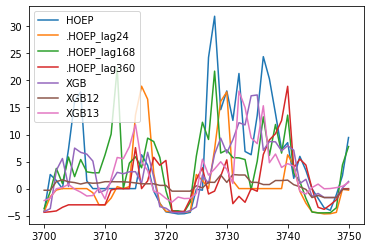

In [2]:
from sklearn.metrics import mean_squared_error
from numpy import corrcoef
import matplotlib.pyplot as plt 
df = data.loc[:8759]

RMSE_lag24 = np.sqrt(mean_squared_error(df.HOEP,df.HOEP_lag24))
print("RMSE HOEP_lag24:",round(RMSE_lag24,2),"Correlation:", corrcoef(df.HOEP,df.HOEP_lag24)[0,1])

RMSE_lag168 = np.sqrt(mean_squared_error(df.HOEP,df.HOEP_lag168))
print("RMSE HOEP_lag168:",round(RMSE_lag168,2),"Correlation:", corrcoef(df.HOEP,df.HOEP_lag168)[0,1])

RMSE_lag360 = np.sqrt(mean_squared_error(df.HOEP,df.HOEP_lag360))
print("RMSE HOEP_lag360:",round(RMSE_lag360,2), "Correlation:", corrcoef(df.HOEP,df.HOEP_lag360)[0,1])

RMSE_XGB = np.sqrt(mean_squared_error(df.HOEP,df.XGB))
print("RMSE XGB:",round(RMSE_XGB,2),"Correlation:", corrcoef(df.HOEP,df.XGB)[0,1])

RMSE_XGB6 = np.sqrt(mean_squared_error(df.HOEP,df.XGB6))
print("RMSE XGB6:",round(RMSE_XGB6,2),"Correlation:", corrcoef(df.HOEP,df.XGB6)[0,1])

RMSE_XGB12 = np.sqrt(mean_squared_error(df.HOEP,df.XGB12))
print("RMSE XGB12:",round(RMSE_XGB12,2),"Correlation:", corrcoef(df.HOEP,df.XGB12)[0,1])

RMSE_XGB13 = np.sqrt(mean_squared_error(df.HOEP,df.XGB13))
print("RMSE XGB13:",round(RMSE_XGB13,2),"Correlation:", corrcoef(df.HOEP,df.XGB13)[0,1])

RMSE_XGB24 = np.sqrt(mean_squared_error(df.HOEP,df.XGB24))
print("RMSE XGB24:",round(RMSE_XGB24,2),"Correlation:", corrcoef(df.HOEP,df.XGB24)[0,1])

test = df.loc[3700:3750]
plt.plot(test.HOEP, label = 'HOEP')
plt.plot(test.HOEP_lag24, label = '.HOEP_lag24')
plt.plot(test.HOEP_lag168, label = '.HOEP_lag168')
plt.plot(test.HOEP_lag360, label = '.HOEP_lag360')
plt.plot(test.XGB, label = 'XGB')
plt.plot(test.XGB12, label = 'XGB12')
plt.plot(test.XGB13, label = 'XGB13')
plt.legend(loc='best')
plt.show()